pip install phik
pip install pandas-profiling
pip install missingno

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

import seaborn as sns
import numpy as np
import missingno as msgn
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import statsmodels.api as sm
import pylab as py

## PNR dataset

In [2]:
pnrs = pd.read_csv('PNR.csv')

In [3]:
# deleting pnrs that has no flight
pnrs.dropna(subset=['ID_PNR_ITI_DEP_YMD_1'], inplace=True)

In [4]:
   pnrs['date'] = pnrs['ID_PNR_CREATION_DTIME_GMT'].apply(lambda x: x.split(' ')[0])
# pnr creation month
pnrs['pnr_create_month'] = pd.to_datetime(pnrs['ID_PNR_CREATION_DTIME_GMT']).dt.month
# pnr creation weekday
pnrs['pnr_create_weekday'] = pd.to_datetime(pnrs['ID_PNR_CREATION_DTIME_GMT']).dt.weekday

pnrs['ID_PNR_ITI_DEP_YMD_1'] = pnrs['ID_PNR_ITI_DEP_YMD_1'].apply(lambda x: datetime.strptime(str(int(x)), '%Y%m%d').strftime('%Y-%m-%d'))
# month of first flight
pnrs['flight_month_1'] = pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_1']).dt.month
# day of first flight
pnrs['flight_weekday_1'] =  pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_1']).dt.weekday

pnrs['ID_PNR_ITI_DEP_YMD_2'] = pnrs['ID_PNR_ITI_DEP_YMD_2'].apply(lambda x: datetime.strptime(str(int(x)), '%Y%m%d').strftime('%Y-%m-%d') if not pd.isna(x) else np.nan)
# month of second flight
pnrs['flight_month_2'] = pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_2']).dt.month # apply(lambda x: int(x.month) if not pd.isna(x) else 0)
# day of second flight
pnrs['flight_weekday_2'] =  pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_2']).dt.weekday

In [5]:
convert_hours = lambda x: datetime(1900, 1, 1, int(x)//100, int(x)%100)
find_hour_difference = lambda x,y : (convert_hours(x)-convert_hours(y)).total_seconds()/60 if not pd.isna(y) else np.nan
def arrival_hour_interval(x):
    if 500 <= x < 1100:
        return 0
    elif 1100 <= x < 1800:
        return 1
    else:
        return 2
    
def pnr_workhour_interval(x):
    if 800 <= x < 1800:
        return 1
    else:
        return 0

In [6]:
# flight duration for first flight
pnrs['flight_duration_1'] = pnrs[['ID_PNR_ITI_ARR_TIME_1', 'ID_PNR_ITI_DEP_TIME_1']].apply(lambda x: find_hour_difference(*x), axis=1)
pnrs['flight_duration_1'] = pnrs['flight_duration_1'].apply(lambda x: x+1440 if x<0 else x)
# flight duration for second flight
pnrs['flight_duration_2'] = pnrs[['ID_PNR_ITI_ARR_TIME_2', 'ID_PNR_ITI_DEP_TIME_2']].apply(lambda x: find_hour_difference(*x), axis=1)
pnrs['flight_duration_2'] = pnrs['flight_duration_2'].apply(lambda x: x+1440 if x<0 else x)
# arrival intervals of flights 05:00-11:00, 11:00-18:00, 18:00-05:00
pnrs['arrival_interval_1'] = pnrs['ID_PNR_ITI_ARR_TIME_1'].apply(arrival_hour_interval)
pnrs['arrival_interval_2'] = pnrs['ID_PNR_ITI_ARR_TIME_2'].apply(arrival_hour_interval)
# day difference between first flight and pnr date
pnrs['diff_pnr_firstflight'] = (pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_1'])-pd.to_datetime(pnrs['ID_PNR_CREATION_DTIME_GMT'])).apply(lambda x: x.days) + 1
# day difference between second flight and first flight
pnrs['diff_second_firstflight'] = np.abs((pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_2'])-pd.to_datetime(pnrs['ID_PNR_ITI_DEP_YMD_1'])).apply(lambda x: x.days))
# is pnr create hour in workhours or not
pnrs['pnr_workhour_interval'] = pnrs['PNR_TIME'].apply(pnr_workhour_interval)
# number of flights in each pnr
pnrs['num_of_flights'] = pnrs['ID_PNR_ITI_DEP_YMD_1'].isna()*-1 + pnrs['ID_PNR_ITI_DEP_YMD_2'].isna()*-1+2
pnrs['date'] = pnrs['ID_PNR_CREATION_DTIME_GMT'].apply(lambda x: x.split(' ')[0])

# tickets dataset

In [7]:
tickets_raw = pd.read_csv('TICKET.csv')

In [8]:
tickets = tickets_raw[tickets_raw['FLIGHT_REASON']=='NONE']

In [9]:
tickets['DEP'] = tickets['OND'].apply(lambda x: x.split('-')[0])
tickets['ARR'] = tickets['OND'].apply(lambda x: x.split('-')[1])
tickets['date'] = tickets['ID_PNR_CREATION_YMD'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))

<ipython-input-9-a80f57b5315e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets['DEP'] = tickets['OND'].apply(lambda x: x.split('-')[0])
<ipython-input-9-a80f57b5315e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tickets['ARR'] = tickets['OND'].apply(lambda x: x.split('-')[1])
<ipython-input-9-a80f57b5315e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [10]:
test_df = pd.merge(tickets, pnrs, on=['PNR_NO', 'date'])

In [11]:
test_df.index = tickets.index

In [12]:
tickets.shape, pnrs.shape, test_df.shape

((8911797, 24), (7249326, 33), (8911797, 55))

In [13]:
label = ['FLIGHT_REASON']

categorical_str1 = [
'ARR',
'DEP',
'ID_PNR_ITI_CABCLASS_1',
'ID_PNR_ITI_SELCLASS_1',
'JRNY_TYP',
'NTNLT1' ] 

categorical_str2 = [
'ID_PNR_ITI_CABCLASS_2',
'ID_PNR_ITI_SELCLASS_2']

categorical_str = categorical_str1 + categorical_str2

categorical_int1 = [
'arrival_interval_1',
'flight_month_1',
'flight_weekday_1',
'pnr_create_month',
'pnr_create_weekday',
'pnr_workhour_interval']

categorical_int2 = [
'arrival_interval_2',
'flight_month_2',
'flight_weekday_2']

categorical_int = categorical_int1 + categorical_int2

numerical1 = [
'CUST_AGE',
'diff_pnr_firstflight', 
'flight_duration_1']

numerical2 = [
'diff_second_firstflight',
'flight_duration_2']

numerical = numerical1+numerical2

passthrough = [
'dep_nat_flag',
'arr_nat_flag',
'CHILD_FLG',
'FAMILY_FLG',
'INFANT_FLG',
'PET_FLG',
'POS_POC_SAME_FLG',
'SAME_SRNAME_FLG',
'SEAT_SELECT_FLG',
'SPORT_FLG',
'XBAG_FIRST_FLT_FLG',
'XBAG_LAST_FLT_FLG',
'XBAG_TWO_WAY_FLT_FLG',
'PNR_PSSG_COUNT']

drops = [
'ID_PNR_CREATION_DTIME_GMT',
'ID_PNR_CREATION_YMD',
'ID_PNR_ITI_ARR_APT_1',
'ID_PNR_ITI_ARR_APT_2',
'ID_PNR_ITI_DEP_APT_1',
'ID_PNR_ITI_DEP_APT_2',
'ID_TKT_NO',
'OND',
'PNR_NO',
'date']

<AxesSubplot:>

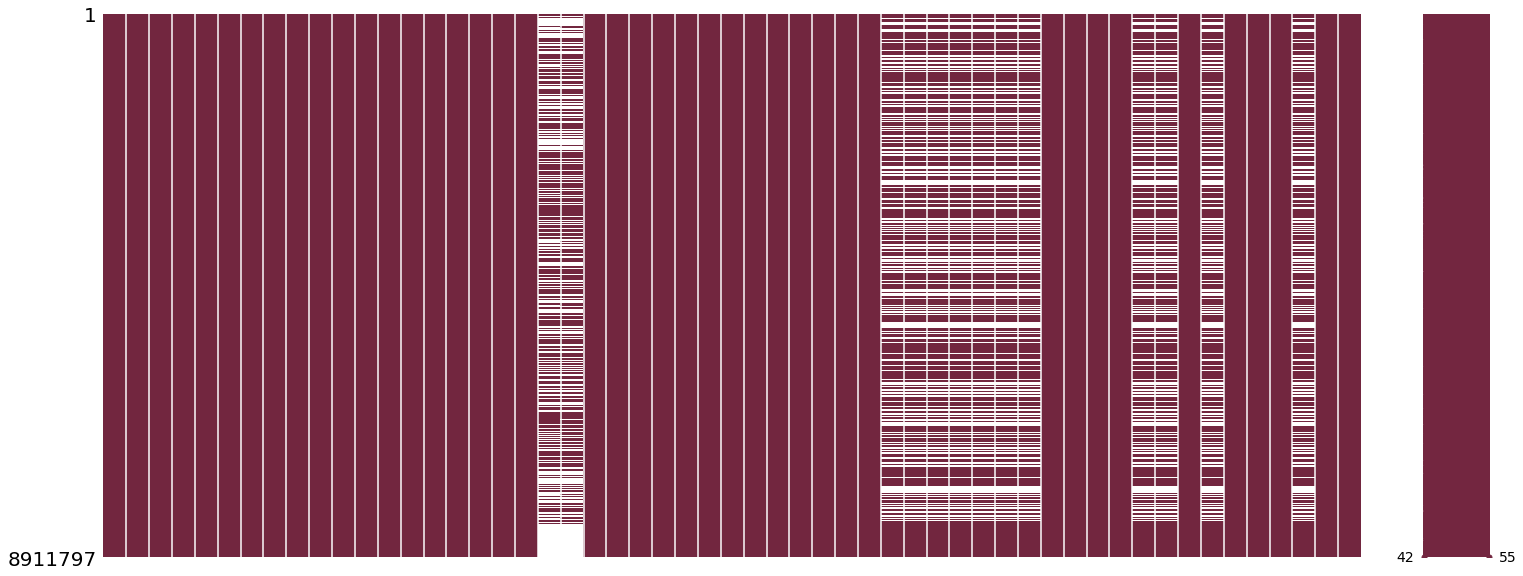

In [14]:
#read in data here
msgn.matrix(test_df,color=(0.45, 0.15, 0.25))

In [15]:
iata_country = pd.read_excel('airport_country.xls', index_col='Unnamed: 0')
airport_country_pairs = dict(zip(iata_country['IATA'], iata_country['Country']))

In [16]:
# is the customer's nationality same with its departure country
test_df['dep_nat_flag'] = (test_df['DEP'].map(airport_country_pairs) == test_df['NTNLT1']).map({True:1, False:0})
# is the customer's nationality same with its arrival country
test_df['arr_nat_flag'] = (test_df['ARR'].map(airport_country_pairs) == test_df['NTNLT1']).map({True:1, False:0})

In [17]:
test_df.shape

(8911797, 57)

In [18]:
def random_undersampling(X, y):
    
    num_sample = y[y=='STUDENT'].shape[0]
    index_1 = y[y=='BUSINESS'].sample(num_sample, random_state=3).index
    index_2 = y[y=='LEISURE'].sample(num_sample, random_state=3).index
    index_3 = y[y=='SECOND HOME'].sample(num_sample, random_state=3).index
    index_4 = y[y=='STUDENT'].index
    
    all_indexes = list(index_1) + list(index_2) + list(index_3) + list(index_4)

    X_ = X.loc[all_indexes]
    y_ = y[all_indexes]
    
    return X_, y_

In [19]:
def create_pipeline_without_clf(clf_name, clf_object):
    
    numeric_transformer1 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    numeric_transformer2 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0.0)),
        ('scaler', StandardScaler())])

    categorical_str_transformer1 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    categorical_str_transformer2 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='-')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])

    categorical_int_transformer1 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-99)),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])
    categorical_int_transformer2 = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-100)),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
                                    transformers=[
                                                  ('num1', numeric_transformer1, numerical1),
                                                  ('num2', numeric_transformer2, numerical2),
                                                  ('cat_str1', categorical_str_transformer1, categorical_str1),
                                                  ('cat_str2', categorical_str_transformer2, categorical_str2),
                                                  ('cat_int1', categorical_int_transformer1, categorical_int1),
                                                  ('cat_int2', categorical_int_transformer2, categorical_int2)], 
                                    n_jobs = -1,
                                    transformer_weights = None,
                                    remainder='passthrough')

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('f_selector', SelectKBest(f_classif, k='all')),
                          (clf_name, clf_object)], verbose=False)
    
    return pipeline

best results obtained from training with below classifiers

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

clf1 = create_pipeline_without_clf('lgb',LGBMClassifier(learning_rate=0.01,max_depth=-1, min_samples_split=2, num_leaves=20, n_estimators= 500))
clf2 = create_pipeline_without_clf('svc',SVC(C= 10, degree= 2, gamma= 0.1, kernel= 'rbf'))
clf3 = create_pipeline_without_clf('log', LogisticRegression(C= 1.0, penalty= 'l2', max_iter=500))
clf4 = create_pipeline_without_clf('rfc',RandomForestClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 500))

estimators_list = [('lgb', clf1),('svc', clf2),('log', clf3),('rfc', clf4)]
stacking = StackingClassifier(estimators=estimators_list,  n_jobs=-1)

In [29]:
# training data is obtained with nb 1-1
train = pd.read_csv('train.csv')

y_train = train['FLIGHT_REASON']
X_train = train[categorical_str+categorical_int+numerical+passthrough]

X_train, y_train = random_undersampling(X_train, y_train)

# test data is constructed with all the NONE values in the FLIGHT_REASON column
# not dropping outliers or nulls
X_test = test_df[categorical_str+categorical_int+numerical+passthrough]

In [30]:
stacking.fit(X_train, y_train)
preds = stacking.predict(X_test)

C:\Users\IsmailKaraman\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
X_test

ARR  DEP ID_PNR_ITI_CABCLASS_1 ID_PNR_ITI_SELCLASS_1 JRNY_TYP  \
0         CDG  IST                     Y                     Q        O   
7         IST  WAW                     Y                     Q        R   
16        IST  AMS                     Y                     M        O   
17        PRG  IST                     Y                     L        R   
18        FCO  IST                     Y                     V        O   
...       ...  ...                   ...                   ...      ...   
10199952  IST  DUS                     Y                     Q        R   
10199954  IST  DUS                     Y                     Q        R   
10199955  GVA  IST                     Y                     V        R   
10199957  FCO  IST                     Y                     L        O   
10199958  IST  SZG                     Y                     W        R   

           NTNLT1 ID_PNR_ITI_CABCLASS_2 ID_PNR_ITI_SELCLASS_2  \
0             NaN                   NaN                   NaN   
7          Turkey                     Y                     V   
16            NaN                   NaN                   NaN   
17         Turkey                     Y                     V   
18         Turkey                   NaN                   NaN   
...           ...                   ...                   ...   
10199952  Germany                     Y                     E   
10199954  Germany                     Y                     E   
10199955   Turkey                     Y                     L   
10199957   Turkey                   NaN                   NaN   
10199958   Turkey                     Y                     W   

          arrival_interval_1  flight_month_1  ...  INFANT_FLG  PET_FLG  \
0                          1               7  ...           0        0   
7                          2              10  ...           0        0   
16                         1               7  ...           0        0   
17                         2               8  ...           0        0   
18                         1              10  ...           0        0   
...                      ...             ...  ...         ...      ...   
10199952                   2              11  ...           0        0   
10199954                   2              11  ...           0        0   
10199955                   0               5  ...           0        0   
10199957                   1               5  ...           0        0   
10199958                   2              12  ...           0        0   

          POS_POC_SAME_FLG  SAME_SRNAME_FLG  SEAT_SELECT_FLG  SPORT_FLG  \
0                        0                0                0          0   
7                        0                0                0          0   
16                       0                0                0          0   
17                       0                0                0          0   
18                       0                0                0          0   
...                    ...              ...              ...        ...   
10199952                 0                0                0          0   
10199954                 0                0                0          0   
10199955                 0                0                0          0   
10199957                 0                0                0          0   
10199958                 0                0                0          0   

          XBAG_FIRST_FLT_FLG  XBAG_LAST_FLT_FLG  XBAG_TWO_WAY_FLT_FLG  \
0                          0                  0                     0   
7                          0                  0                     0   
16                         0                  0                     0   
17                         0                  0                     0   
18                         0                  0                     0   
...                      ...                ...                   ...   
10199952                   

In [ ]:
stop

In [33]:
len(preds)

8911797

In [35]:
tickets_raw.loc[X_test.index, 'FLIGHT_REASON'] = preds

In [37]:
tickets_raw.to_csv('TICKET_RESULT.csv')

In [41]:
only_results = pd.DataFrame(preds, index=X_test.index,columns=['FLIGHT_REASON'])

In [42]:
only_results.value_counts()

FLIGHT_REASON
BUSINESS         4239398
LEISURE          3034916
STUDENT           872939
SECOND HOME       764544
dtype: int64

In [46]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [47]:
def print_metrics(y_pred, y_test, model):
    print("Model results: ", type(model).__name__)
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    cm = confusion_matrix(y_test,y_pred, labels= model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= model.classes_)
    disp.plot()

In [ ]:
y = train['FLIGHT_REASON']
X = train[categorical_str+categorical_int+numerical+passthrough]

X, y = random_undersampling(X, y)

X_train, X_test1, y_train, y_test1 = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

stacking = StackingClassifier(estimators=estimators_list,  n_jobs=-1)

stacking.fit(X_train, y_train)
preds1 = stacking.predict(X_test1)

0.9482056308370941
Model results:  StackingClassifier
              precision    recall  f1-score   support

    BUSINESS       0.92      0.95      0.94       212
     LEISURE       0.94      0.89      0.92       211
 SECOND HOME       0.97      0.97      0.97       212
     STUDENT       0.96      0.98      0.97       211

    accuracy                           0.95       846
   macro avg       0.95      0.95      0.95       846
weighted avg       0.95      0.95      0.95       846

Confusion matrix:


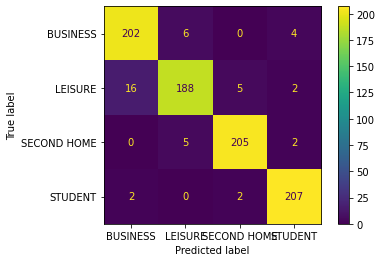

In [50]:
print(f1_score(preds1, y_test1, average='weighted'))
print_metrics(preds1, y_test1, stacking)

In [51]:
preds2 = stacking.predict(X_test)
rres = pd.DataFrame(preds2, index=X_test.index,columns=['FLIGHT_REASON'])
rres.value_counts()

FLIGHT_REASON
BUSINESS         4377142
LEISURE          2957754
SECOND HOME       806759
STUDENT           770142
dtype: int64

In [53]:
FLIGHT_REASON1 = {
'BUSINESS' :        4239398,
'LEISURE'   :       3034916,
'STUDENT'     :      872939,
'SECOND HOME' :      764544}

In [55]:
sum(FLIGHT_REASON1.values())

8911797

In [60]:
[i/sum(FLIGHT_REASON1.values()) for i in FLIGHT_REASON1.values()]

[0.4757063025560389,
 0.34055039628932304,
 0.09795319619600851,
 0.08579010495862956]

In [62]:
FLIGHT_REASON2 = dict(rres.value_counts())

In [63]:
[i/sum(FLIGHT_REASON2.values()) for i in FLIGHT_REASON2.values()]

[0.491162668988084,
 0.33189198542112214,
 0.0905270844926113,
 0.08641826109818256]

In [67]:
X_test[preds!=preds2].loc[20]

ARR                        BUD
DEP                        IST
ID_PNR_ITI_CABCLASS_1        Y
ID_PNR_ITI_SELCLASS_1        W
JRNY_TYP                     O
NTNLT1                     NaN
ID_PNR_ITI_CABCLASS_2      NaN
ID_PNR_ITI_SELCLASS_2      NaN
arrival_interval_1           2
flight_month_1               3
flight_weekday_1             2
pnr_create_month             3
pnr_create_weekday           4
pnr_workhour_interval        1
arrival_interval_2           2
flight_month_2             NaN
flight_weekday_2           NaN
CUST_AGE                   NaN
diff_pnr_firstflight        12
flight_duration_1          5.0
diff_second_firstflight    NaN
flight_duration_2          NaN
dep_nat_flag                 0
arr_nat_flag                 0
CHILD_FLG                    0
FAMILY_FLG                   1
INFANT_FLG                   0
PET_FLG                      0
POS_POC_SAME_FLG             0
SAME_SRNAME_FLG              1
SEAT_SELECT_FLG              0
SPORT_FLG                    0
XBAG_FIR